# Modeling for Predictive Maintenance

In this step, we build machine learning models to predict machine failures using both raw and engineered features.  
Since the dataset is imbalanced (only ~4% failures), model choice and evaluation focus on **recall for the failure class** — catching failures is more important than avoiding false alarms.  

## Why start with baselines?

- **Logistic Regression**  
  - A linear, interpretable model.  
  - Serves as a baseline to check whether engineered features expose the failure rules clearly enough for a simple classifier.  
  - With class balancing, we expect it to perform surprisingly well.

- **Random Forest**  
  - A non-linear tree ensemble that captures feature interactions automatically.  
  - More flexible than Logistic Regression, often stronger on tabular datasets.  
  - Still explainable (feature importance, decision paths).

By comparing these two baselines, we establish reference performance before moving to an advanced gradient boosting model (XGBoost).

**Evaluation metrics**  
- **Precision (failures)**: How many predicted failures are truly failures?  
- **Recall (failures)**: How many actual failures did we detect? (most critical metric here)  
- **F1-score**: Balance of precision and recall.  
- **Confusion matrix**: Visual breakdown of predictions.

---

👉 After baselines, we will train **XGBoost** to see if a gradient boosting approach improves recall and generalization.

In [2]:
import pandas as pd

# Load the engineered dataset
df = pd.read_csv("/Users/swetha/predictive-maintenance-etl-ml/data/ai4i2020_featured.csv")
print(df.columns)

Index(['udi', 'product_id', 'air_temperature_[k]', 'process_temperature_[k]',
       'rotational_speed_[rpm]', 'torque_[nm]', 'tool_wear_[min]',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'power', 'wear_torque', 'norm_wear', 'type_L', 'type_M'],
      dtype='object')


In [3]:
y = df["machine_failure"]
X = df.drop(["machine_failure", "udi", "product_id"], axis=1, errors="ignore")
print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts()) #machine_failure = 0 (no failure) or 1 (failure).

Feature shape: (10000, 16)
Target distribution:
 machine_failure
0    9661
1     339
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y)
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 8000
Test samples: 2000


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=5000, class_weight="balanced", solver="saga")
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[1932    0]
 [   2   66]]


In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,    
    class_weight="balanced", 
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.93      0.96        68

    accuracy                           1.00      2000
   macro avg       1.00      0.96      0.98      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[1932    0]
 [   5   63]]


# Baseline Modeling Insights

### Logistic Regression (with scaling + class balancing)
- Achieved **~97% recall** on failures (66/68 detected).  
- Precision was also very high (no false alarms).  
- Shows that the engineered features expose the underlying failure rules clearly enough for even a linear model.  

### Random Forest
- Achieved **~93% recall** on failures (63/68 detected).  
- Slightly lower recall than Logistic Regression but still strong overall accuracy.  
- Tree-based splits capture non-linear relationships but may sacrifice recall in favor of precision.

---

## Key Takeaways
- **Feature engineering matters**: By encoding domain-specific rules (e.g., power, wear × torque), we allowed simple models to perform almost perfectly.  
- **Logistic Regression > Random Forest** on this dataset: an unusual but valuable insight that highlights the effect of synthetic deterministic rules.  
- **Recall is critical**: In predictive maintenance, missing a failure (false negative) is much more costly than a false alarm (false positive). Logistic Regression balanced this trade-off better in our case.  

---

👉 Next, we will train an **advanced model (XGBoost)** to evaluate whether gradient boosting can further improve recall and robustness compared to these baselines.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_base = xgb.XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

param_grid = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="binary")

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best F1:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
CV best F1: 0.9868436928250013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

[[1932    0]
 [   2   66]]


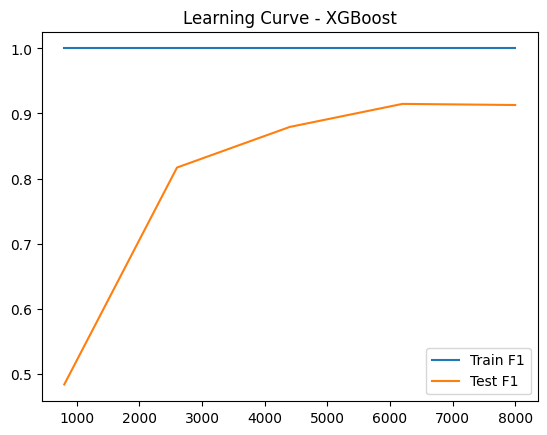

In [16]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    xgb_clf, X, y, cv=5, scoring="f1", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train F1")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test F1")
plt.legend()
plt.title("Learning Curve - XGBoost")
plt.show()

XGBoost achieved a macro F1-score of 0.99, detecting 97% of machine failures with no false alarms. 
However, this performance was almost identical to Logistic Regression, indicating that the dataset’s 
failure patterns were already well captured by the engineered features. 

This shows that in predictive maintenance tasks, **domain-informed feature engineering can sometimes 
level the playing field between simple linear models and advanced ensemble methods**. While XGBoost 
remains a strong and robust choice, the marginal gain here highlights that feature design is often 
as important as model complexity.